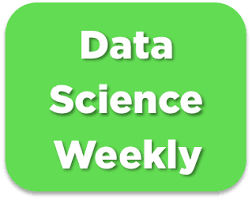

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [143]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,  OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display

# Read file with labels

In [111]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [112]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


# Explore dataset

In [113]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
data_sample = data.sample(10000)

In [114]:
print("Number of rows :", data_sample.shape[0])

print("Basics statistics")
display(data_sample.describe(include="all"))

print("percentage of missing values:")
display(100 * data_sample.isnull().sum() / data_sample.shape[0])

Number of rows : 10000
Basics statistics


,country,age,new_user,source,total_pages_visited,converted
count,10000,10000.000000,10000.000000,10000,10000.000000,10000.0000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,5563,NaN,NaN,4957,NaN,NaN
mean,NaN,30.678900,0.684500,NaN,4.928000,0.0356
std,NaN,8.223658,0.464738,NaN,3.399231,0.1853
min,NaN,17.000000,0.000000,NaN,1.000000,0.0000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.0000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.0000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.0000


percentage of missing values:


country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

In [115]:
fig = px.scatter(data_sample, x= "age", y="total_pages_visited", color = data_sample['converted'].astype('str'), labels = {'color': 'converted'}, 
                 height=600, width=800)

fig.show()

In [116]:
num_features = ["age", "total_pages_visited"]
cat_order = {
    'converted': [0, 1],
}

def display_distribution(f):
    fig = px.histogram(data_sample, f, color = 'converted', facet_row = 'converted', histnorm = 'probability', 
                       category_orders = cat_order, height=600, width=800)
    fig.show()
    
display_distribution('age')

1 outlier age at 111

In [117]:
data_sample = data_sample[data_sample["age"] < 111]
data_sample.describe(include="all")

,country,age,new_user,source,total_pages_visited,converted
count,10000,10000.000000,10000.000000,10000,10000.000000,10000.0000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,5563,NaN,NaN,4957,NaN,NaN
mean,NaN,30.678900,0.684500,NaN,4.928000,0.0356
std,NaN,8.223658,0.464738,NaN,3.399231,0.1853
min,NaN,17.000000,0.000000,NaN,1.000000,0.0000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.0000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.0000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.0000


In [118]:
display_distribution('total_pages_visited')

In [119]:
display_distribution('country')

In [120]:
display_distribution('new_user')

In [121]:
display_distribution('source')

# Make your model

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

In [122]:
categorical_indices = []
target_variable = 'converted'

In [123]:
X = data.drop(target_variable, axis = 1)
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['country', 'age', 'new_user', 'source', 'total_pages_visited'], dtype='object')



In [124]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0, stratify=Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



## Training pipeline

In [125]:
# Create pipeline for numeric features
numeric_features = ["age", "total_pages_visited"]  
numeric_transformer = Pipeline(
    steps=[
         ("scaler", StandardScaler()),
    ]
)

# Create pipeline for categorical features
categorical_features = ["country", "new_user", "source"]  
categorical_transformer = Pipeline(
    steps=[
        (
            "encoder",
            OneHotEncoder(drop="first"),
        ), 
    ]
)

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [126]:
# Put here all the preprocessings
print("Encoding categorical features and standardizing numerical features...")

X_train = preprocessor.fit_transform(X_train)
print("...Done")
print(X_train[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.91458053 -0.85939501  0.          0.          0.          0.
   1.          0.        ]
 [-0.30994956 -0.85939501  0.          0.          0.          0.
   0.          0.        ]
 [-0.06809718  0.63639894  0.          0.          0.          1.
   0.          1.        ]
 [ 0.77838618 -0.56023622  0.          1.          0.          1.
   0.          1.        ]
 [ 0.05282902  0.93555773  0.          0.          1.          1.
   0.          0.        ]]


In [127]:
# Train model
print("Train model...")
classifier = LogisticRegression()  
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [128]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



## Test pipeline

In [129]:
# Use X_test, and the same preprocessings as in training pipeline, 
# but call "transform()" instead of "fit_transform" methods (see example below)

print("Encoding categorical features and standardizing numerical features...")

X_test = preprocessor.transform(X_test)
print("...Done")
print(X_test[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.79365434  2.73051047  0.          0.          0.          1.
   0.          0.        ]
 [ 0.53653379  0.03808136  0.          0.          1.          0.
   1.          0.        ]
 [-0.18902337 -0.26107743  0.          0.          1.          0.
   1.          0.        ]
 [ 0.05282902  0.93555773  0.          0.          0.          1.
   0.          1.        ]
 [-0.30994956 -0.85939501  0.          0.          1.          1.
   0.          1.        ]]


In [130]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



## Performance assessment

In [131]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7641111483093405
f1-score on test set :  0.76


In [132]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[246893    967]
 [  2556   5706]]

Confusion matrix on test set : 
[[27435   105]
 [  291   627]]



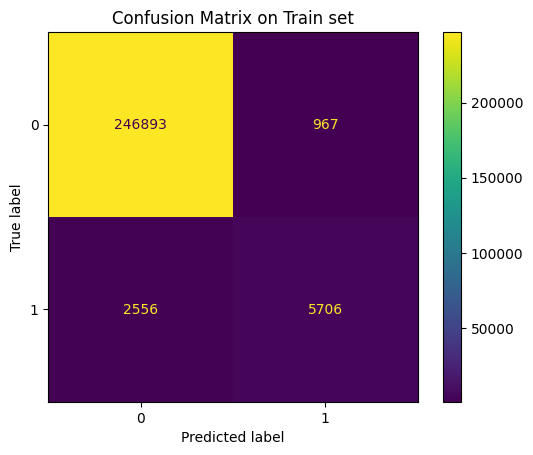

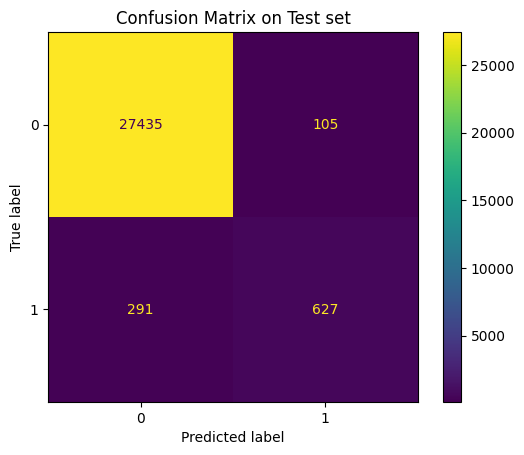

In [133]:
# Visualize confusion matrices
_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="Confusion Matrix on Train set"
)  # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(
    classifier, X_train, Y_train, ax=ax
)  # ConfusionMatrixDisplay from sklearn
plt.show()

_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="Confusion Matrix on Test set"
)  # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(
    classifier, X_test, Y_test, ax=ax
)  # ConfusionMatrixDisplay from sklearn
plt.show()

**Our baseline model reaches a f1-score of almost 76%. 🚀🚀**

# Feature engineering

In [134]:
print("Dropping outliers in the following columns : age...")

data = data[data["age"] < 100]

print("...Done, number of lines remaining : ", data.shape[0])

data.head()

Dropping outliers in the following columns : age...
...Done, number of lines remaining :  284578


,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [135]:
print("Adding some features with existing data...")

data["globe_part"] = data["country"].apply(lambda x : "oriental" if x == "China"
                                           else "occidental")
data["age_class"] = data["age"].apply(lambda x : "<30" if x < 30
                                      else "30 - 50" if 30 < x < 50
                                      else ">50")
data["age_2"] = data["age"]**2


data["ads"] = data["source"].apply(lambda x : 1 if x == "Ads"
                                   else 0)
data["nb_pages"] = data["total_pages_visited"].apply(lambda x : "<10" if x < 10
                                                     else "10-20" if 10 < x < 20
                                                     else ">20")

print("...Done")
data.head()

Adding some features with existing data...
...Done


,country,age,new_user,source,total_pages_visited,converted,globe_part,age_class,age_2,ads,nb_pages
0,China,22,1,Direct,2,0,oriental,<30,484,0,<10
1,UK,21,1,Ads,3,0,occidental,<30,441,1,<10
2,Germany,20,0,Seo,14,1,occidental,<30,400,0,10-20
3,US,23,1,Seo,3,0,occidental,<30,529,0,<10
4,US,28,1,Direct,3,0,occidental,<30,784,0,<10


# Other models test & train 

In [136]:
target_variable = 'converted'
X = data.drop(target_variable, axis = 1)
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'globe_part', 'age_class', 'age_2', 'ads', 'nb_pages'],
      dtype='object')



In [137]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0, stratify=Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [138]:
# Create pipeline for numeric features
numeric_featuresV2 = ["age", "total_pages_visited", "age_2"]  
numeric_features = ["age", "total_pages_visited", ]#"country_conversion_rate", "source_interaction", "newuser_due_to_pages_visited"]  
numeric_transformer = Pipeline(
    steps=[
         ("scaler", StandardScaler()),
    ]
)

# Create pipeline for categorical features
categorical_featuresV2 = ["country", "new_user", "source", "globe_part", "age_class", "ads", "nb_pages"]
categorical_features = ["country", "new_user", "source"]  
categorical_transformer = Pipeline(
    steps=[
        (
            "encoder",
            OneHotEncoder(drop="if_binary"),
        ), 
    ]
)

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_featuresV2),
        ("cat", categorical_transformer, categorical_featuresV2),
    ]
)

In [139]:
# Put here all the preprocessings
print("Encoding categorical features and standardizing numerical features...")

X_train = preprocessor.fit_transform(X_train)
print("...Done")
print(X_train[0:5,:])

# Use X_test, and the same preprocessings as in training pipeline, 
# but call "transform()" instead of "fit_transform" methods (see example below)

print("Encoding categorical features and standardizing numerical features...")

X_test = preprocessor.transform(X_test)
print("...Done")
print(X_test[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-1.51987065 -0.26099836 -1.23985271  0.          0.          0.
   1.          0.          0.          0.          1.          0.
   0.          1.          0.          0.          0.          1.
   0.        ]
 [ 2.2307148   0.03829244  2.55626306  1.          0.          0.
   0.          0.          0.          0.          1.          1.
   1.          0.          0.          0.          0.          1.
   0.        ]
 [ 1.86775492 -0.56028917  2.03537091  1.          0.          0.
   0.          1.          0.          0.          1.          1.
   1.          0.          0.          0.          0.          1.
   0.        ]
 [-1.51987065 -1.15887077 -1.23985271  0.          0.          0.
   1.          0.          1.          0.          0.          0.
   0.          1.          0.          1.          0.          1.
   0.        ]
 [-1.03592414  0.33758325 -0.94742203  0.          0.          0.
   1

## Basic logistic regression

In [144]:
# Train model
print("Train model...")
classifier_v2 = LogisticRegression()  
classifier_v2.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [145]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier_v2.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier_v2.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [146]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7633393586396198
f1-score on test set :  0.7719087635054022


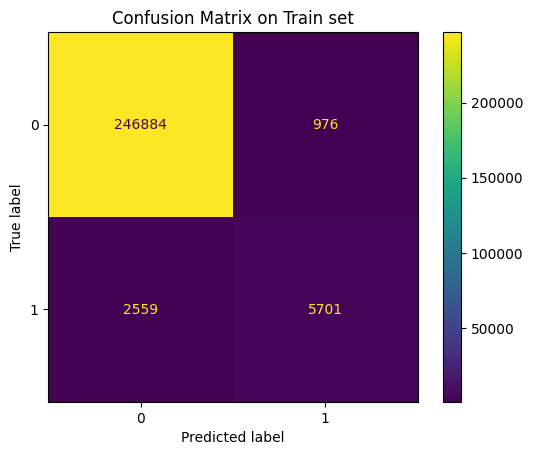

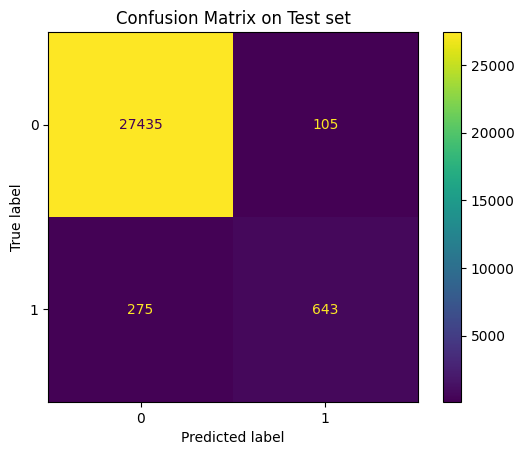

In [90]:
# Visualize confusion matrices
_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="Confusion Matrix on Train set"
)  # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(
    classifier_v2, X_train, Y_train, ax=ax
)  # ConfusionMatrixDisplay from sklearn
plt.show()

_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="Confusion Matrix on Test set"
)  # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(
    classifier_v2, X_test, Y_test, ax=ax
)  # ConfusionMatrixDisplay from sklearn
plt.show()

## Bagging - logistic regression

In [88]:
print("Grid search...")
logistic_regression = LogisticRegression(max_iter = 10000)
model = BaggingClassifier(estimator=logistic_regression)

# Grid of values to be tested
params = {
    'estimator__C': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 10.0, 50.0],
    'n_estimators': [4, 5, 8, 10, 20,],
}
print(params)
gridsearch_bag_logreg = GridSearchCV(
    model, param_grid=params, cv=8, verbose = 1) 
  # cv : the number of folds to be used for CV
gridsearch_bag_logreg.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch_bag_logreg.best_params_)
print("Best validation accuracy : ", gridsearch_bag_logreg.best_score_)
print()
print("Accuracy on training set : ", gridsearch_bag_logreg.score(X_train, Y_train))
print("Accuracy on test set : ", gridsearch_bag_logreg.score(X_test, Y_test))

Grid search...
{'estimator__C': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 10.0, 50.0], 'n_estimators': [4, 5, 8, 10, 20]}
Fitting 8 folds for each of 45 candidates, totalling 360 fits
...Done.
Best hyperparameters :  {'estimator__C': 4.0, 'n_estimators': 4}
Best validation accuracy :  0.9862134936748399

Accuracy on training set :  0.9861588317975949
Accuracy on test set :  0.9866118490406915


In [89]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearch_bag_logreg.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch_bag_logreg.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [90]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7619047619047619
f1-score on test set :  0.7708959711365003


## Adaboost - logistic regression

In [39]:
print("Grid search...")
logistic_regression = LogisticRegression(max_iter = 10000)
adaboost_logreg = AdaBoostClassifier(estimator=logistic_regression, algorithm="SAMME")

# Grid of values to be tested
params = {
    'estimator__C': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 10.0, 50.0],
    'n_estimators': [2, 3, 4, 5, 8, 10, 20,],
}
print(params)
gridsearch_ada_log = GridSearchCV(
    adaboost_logreg, param_grid=params, cv=5, verbose = 1)  
gridsearch_ada_log.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch_ada_log.best_params_)
print("Best validation accuracy : ", gridsearch_ada_log.best_score_)
print()
print("Accuracy on training set : ", gridsearch_ada_log.score(X_train, Y_train))
print("Accuracy on test set : ", gridsearch_ada_log.score(X_test, Y_test))


Grid search...
{'estimator__C': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 10.0, 50.0], 'n_estimators': [2, 3, 4, 5, 8, 10, 20]}
Fitting 5 folds for each of 63 candidates, totalling 315 fits
...Done.
Best hyperparameters :  {'estimator__C': 4.0, 'n_estimators': 8}
Best validation accuracy :  0.9846361080743401

Accuracy on training set :  0.9845150710604404
Accuracy on test set :  0.9848900133530114


In [40]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearch_ada_log.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch_ada_log.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [41]:
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7458995386981035
f1-score on test set :  0.7531572904707233


## Adaboost - Decision Tree

In [114]:
print("Grid search...")
dt = DecisionTreeClassifier()
adaboost_dt = AdaBoostClassifier(estimator=dt, algorithm="SAMME")

# Grid of values to be tested
params = {
   'estimator__max_depth': [8, 10, 12],
    'estimator__min_samples_leaf': [1, 2, 3],
    'estimator__min_samples_split': [6, 8, 10],
    'n_estimators': [2, 4, 6, 8, 10, 12],
}
print(params)
gridsearch_ada_dt = GridSearchCV(
    adaboost_dt, param_grid=params, cv=10, verbose = 1)  
gridsearch_ada_dt.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch_ada_dt.best_params_)
print("Best validation accuracy : ", gridsearch_ada_dt.best_score_)
print()
print("Accuracy on training set : ", gridsearch_ada_dt.score(X_train, Y_train))
print("Accuracy on test set : ", gridsearch_ada_dt.score(X_test, Y_test))


Grid search...
{'estimator__max_depth': [8, 10, 12], 'estimator__min_samples_leaf': [1, 2, 3], 'estimator__min_samples_split': [6, 8, 10], 'n_estimators': [2, 4, 6, 8, 10, 12]}
Fitting 10 folds for each of 162 candidates, totalling 1620 fits
...Done.
Best hyperparameters :  {'estimator__max_depth': 8, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 6, 'n_estimators': 2}
Best validation accuracy :  0.985709823520225

Accuracy on training set :  0.9863657660471654
Accuracy on test set :  0.9855576639257854


In [115]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearch_ada_dt.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch_ada_dt.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [116]:
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7708962078467393
f1-score on test set :  0.7578078962875663


## Gradient Boostin Classifier - XGBoost

In [153]:
# Perform grid search
print("Grid search...")
xgboost = XGBClassifier()

# Grid of values to be tested
params = {
    'max_depth': [2, 3, 4, 5, 6, 8],
    'min_child_weight': [10, 12, 15,20,25,30],
    'n_estimators': [20, 25, 30, 50]
}
print(params)
gridsearch_xgboost = GridSearchCV(xgboost, param_grid = params, cv = 3, verbose = 1) # cv : the number of folds to be used for CV
gridsearch_xgboost.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch_xgboost.best_params_)
print("Best validation accuracy : ", gridsearch_xgboost.best_score_)
print()
print("Accuracy on training set : ", gridsearch_xgboost.score(X_train, Y_train))
print("Accuracy on test set : ", gridsearch_xgboost.score(X_test, Y_test))


Grid search...
{'max_depth': [2, 3, 4, 5, 6, 8], 'min_child_weight': [10, 12, 15, 20, 25, 30], 'n_estimators': [20, 25, 30, 50]}
Fitting 3 folds for each of 144 candidates, totalling 432 fits
...Done.
Best hyperparameters :  {'max_depth': 5, 'min_child_weight': 25, 'n_estimators': 30}
Best validation accuracy :  0.9861432164960914

Accuracy on training set :  0.9863345306887397
Accuracy on test set :  0.9863658725138801


In [154]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearch_xgboost.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch_xgboost.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on training set...


...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [155]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7675962815405046
f1-score on test set :  0.7701421800947867


## MLPClassifier

In [140]:
from sklearn.neural_network import MLPClassifier

mlpc = MLPClassifier(activation='logistic', solver='lbfgs', alpha=0.001)
mlpc.fit(X_train, Y_train)

MLPClassifier(activation='logistic', alpha=0.001, solver='lbfgs')

In [141]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = mlpc.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = mlpc.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [142]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7652382219856269
f1-score on test set :  0.7692307692307693


## Voting

In [161]:
voting = VotingClassifier(
    estimators=[("logistic", classifier_v2), ("bagging_logreg", gridsearch_bag_logreg), ("xgboost", gridsearch_xgboost), ("MLPclassifier", mlpc)],
    voting="soft",
)  # soft: use probabilities for voting
voting.fit(X_train, Y_train)
print("Accuracy on training set : ", voting.score(X_train, Y_train))
print("Accuracy on test set : ", voting.score(X_test, Y_test))

# Predictions on training set
print("Predictions on training set...")
Y_train_pred = voting.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = voting.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

Fitting 8 folds for each of 45 candidates, totalling 360 fits
Fitting 3 folds for each of 144 candidates, totalling 432 fits
Accuracy on training set :  0.986233015773856
Accuracy on test set :  0.9865767095368614
Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]

f1-score on train set :  0.7648392690409497
f1-score on test set :  0.7715311004784688


# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [151]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

gridsearch_xgboost.fit(X,Y)

Fitting 8 folds for each of 120 candidates, totalling 960 fits


GridSearchCV(cv=8,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 8],
                         'min_child_weight': [1, 2, 4, 5, 8],
                         'n_estimators': [10, 12, 15, 20]},
             verbose=1)

In [152]:
Y_pred = gridsearch_xgboost.predict(X)
print("f1-score on train set : ", f1_score(Y, Y_pred))

f1-score on train set :  0.7668957275171796


In [156]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

data_without_labels["globe_part"] = data_without_labels["country"].apply(lambda x : "oriental" if x == "China"
                                           else "occidental")
data_without_labels["age_class"] = data_without_labels["age"].apply(lambda x : "<30" if x < 30
                                      else "30 - 50" if 30 < x < 50
                                      else ">50")
data_without_labels["age_2"] = data_without_labels["age"]**2


data_without_labels["ads"] = data_without_labels["source"].apply(lambda x : 1 if x == "Ads"
                                   else 0)
data_without_labels["nb_pages"] = data_without_labels["total_pages_visited"].apply(lambda x : "<10" if x < 10
                                                     else "10-20" if 10 < x < 20
                                                     else ">20")

# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
features_list = ["age", "total_pages_visited", "age_2", "country", "new_user", "source", "globe_part", "age_class", "ads", "nb_pages"]
X_without_labels = data_without_labels.loc[:, features_list]



Prediction set (without labels) : (31620, 5)


In [157]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = preprocessor.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.31000438  3.33049128 -0.39911451  0.          0.          1.
   0.          0.          0.          0.          1.          0.
   0.          1.          0.          0.          1.          0.
   0.        ]
 [-1.03592414  0.03829244 -0.94742203  0.          0.          1.
   0.          1.          0.          1.          0.          0.
   0.          1.          0.          0.          0.          1.
   0.        ]
 [ 0.17394213 -1.15887077  0.03953151  1.          0.          0.
   0.          1.          0.          0.          1.          1.
   1.          0.          0.          0.          0.          1.
   0.        ]
 [ 0.17394213  0.33758325  0.03953151  0.          0.          0.
   1.          1.          1.          0.          0.          0.
   1.          0.          0.          1.          0.          1.
   0.        ]
 [-0.67296426 -0.56028917 -0.6897175   1.          0.          0.
   0

In [162]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': voting.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_youenn-patat-voting.csv', index=False)


## Analyzing the coefficients and interpreting the result
**In this template, we just trained a model with only one feature (total_pages_visited), so there's no analysis to be done about the feature importance 🤔**

**Once you've included more features in your model, please take some time to analyze the model's parameters and try to find some lever for action to improve the newsletter's conversion rate 😎😎**

# Conclusion

We can't reach an higher score at one moment due to the qualitate of the dataset to studied. We have a lot of 0 and less 1 so the different models are limited to learn for the prediction of 1. That means we are obligated to have a partial error on it that stop the maximum f1 score around 0.75, 0.76.